# Control arm

In [1]:
import numpy as np
import pandas as pd
import pyvista as pv
import deepxde as dde

from pinnDSE.geom import MeshGeom
from pinnDSE.viz import *
from pinnDSE.elasticity import *
from pinnDSE.bc import *

Using TensorFlow 2 backend.

Instructions for updating:
non-resource variables are not supported in the long term


2 read mesh: 0.008976221084594727


3 coordinate transform: 3.442821741104126
2 read results: 4.859035015106201
1 total mesh and result loading: 5.031573295593262
1 total edge processing: 0.34707164764404297


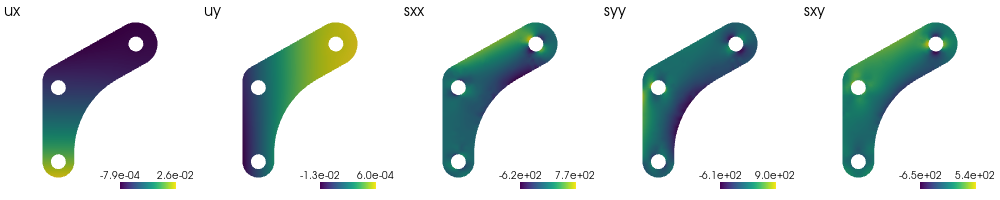

In [2]:
# load mesh and solver results
op2File = 'data/controlArm/v2.0/controlArm02.op2'
geom = MeshGeom(op2File, thickness=1.0)
plotScalarFields(geom.mesh, geom.resDf)

In [2]:
# # load using the alternative format
# meshFile = 'data/controlArm/v1.0/controlArm01_nom.vtk'
# pickleFile = 'data/controlArm/v1.0/controlArm01_nom.p'
# geom = MeshGeom(meshFile=meshFile, pickleFile=pickleFile)
# plotScalarFields(geom.mesh, geom.resDf)

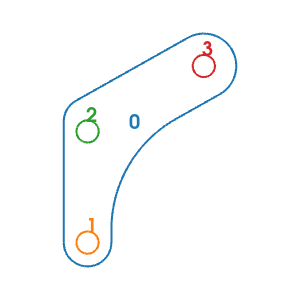

In [3]:
drawBoundaries(geom.bndDict)

Compiling model...
Building feed-forward neural network...
'build' took 0.060834 s

'compile' took 1.470800 s

Initializing variables...
Training model...

Step      Train loss                                                                                                                            Test loss                                                                                                                             Test metric
0         [3.62e+00, 1.47e+01, 3.86e+04, 4.65e+05, 2.23e+03, 7.59e-06, 1.60e-05, 1.17e+02, 3.20e+01, 4.97e+03, 3.77e+01, 4.85e+03, 6.38e+01]    [2.76e+00, 1.58e+01, 4.05e+04, 5.13e+05, 2.70e+03, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  

Best model at step 0:
  train loss: 5.16e+05
  test loss: 5.56e+05
  test metric: []

'train' took 1.006361 s

Compiling model...
'compile' took 1.062190 s

Initializing variables...
Training model...

Step      Train loss                                                

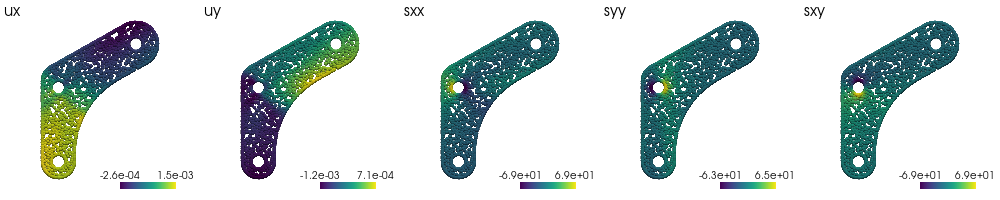

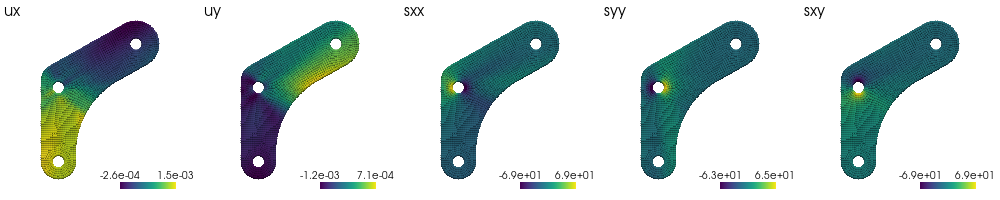

In [17]:
# supports
xBc = SupportBC(geom, bndId=3, U=0, component=0)
yBc = SupportBC(geom, bndId=3, U=0, component=1)

# traction free edges
xTr0 = TractionBC(geom, bndId=0, T=0, component=0)
yTr0 = TractionBC(geom, bndId=0, T=0, component=1)

# external loads
xTr1 = TractionBC(geom, bndId=1, T=34/geom.bndAreaDict[2], component=0)
yTr1 = TractionBC(geom, bndId=1, T=0, component=1)

xTr2 = TractionBC(geom, bndId=2, T=-34/geom.bndAreaDict[2], component=0)
yTr2 = TractionBC(geom, bndId=2, T=0, component=1)

# problem setup
bndNumSamplesDir = {0:800, 1:100, 2:100, 3:100}
paramDict = {'E':2.1e5, 'nu':0.3}
bcList = [xBc,yBc,xTr0,yTr0,xTr1,yTr1,xTr2,yTr2]
data = StrctPDE(geom, 
            elasticityEqs, 
            bcList, 
            num_domain=1000, 
            num_boundary_dir=bndNumSamplesDir, 
            num_test=500,
            paramDict=paramDict)

for bc in bcList:
    if isinstance(bc, TractionBC): 
        bc.train_n = data.train_n

# build model
net = dde.maps.FNN([2] + [64]*4  + [5], "tanh", "Glorot uniform")
outScales = np.array([1e-2, 1e-2, 1e2, 1e2, 1e2]) # [ux,uy,sxx,syy,sxy]
net.apply_output_transform(lambda x,y : y*outScales) 
model = dde.Model(data, net)

# get the unweighted loss values
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=0)
lw = losshistory.loss_train[0]**(-1) 
lw[11] *= 1e6
lw[12] *= 1e3


# train
model.compile("adam", lr=0.001, loss_weights=lw)
losshistory, train_state = model.train(epochs=1000, display_every=100)

# model.compile("L-BFGS-B", loss_weights=lw)
# model.train_op.optimizer_kwargs['options']['maxiter']=2000
# model.train_op.optimizer_kwargs['options']['maxfun']=2000
# losshistory, train_state = model.train(display_every=100)

# model.compile("adam", lr=0.0001, loss_weights=lw)
# losshistory, train_state = model.train(epochs=1000, display_every=100)

# model.compile("L-BFGS-B", loss_weights=lw)
# model.train_op.optimizer_kwargs['options']['maxiter']=2000
# model.train_op.optimizer_kwargs['options']['maxfun']=2000
# losshistory, train_state = model.train(display_every=100)

# test
pred = model.predict(data.train_x)
predDf = pd.DataFrame(pred, columns=['ux', 'uy', 'sxx', 'syy', 'sxy'])
pc = pv.PolyData(addZ(data.train_x))
plotScalarFields(pc, predDf)

pred = model.predict(geom.mesh.points[:,:2])
predDf = pd.DataFrame(pred, columns=['ux', 'uy', 'sxx', 'syy', 'sxy'])
pc = pv.PolyData(geom.mesh.points)
plotScalarFields(pc, predDf)

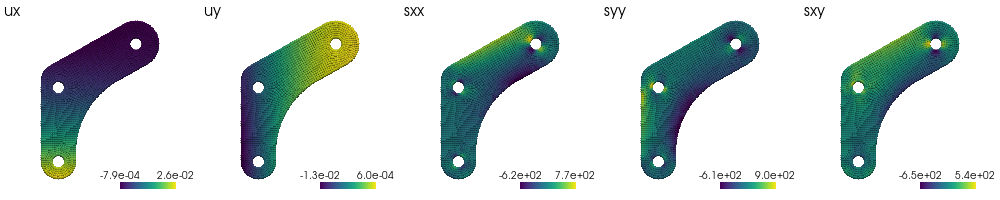

In [18]:
plotScalarFields(pc, geom.resDf)

In [19]:
bcNames = ['xBc','yBc','xTr0','yTr0','xTr1','yTr1','xTr2','yTr2']
# lines = alt.Chart(pd.DataFrame({'step':[1000,3000,4000]})).mark_rule(color='gray').encode(x='step:Q')
lossPlot(losshistory, bcNames)

alt.Chart(...)

In [20]:
model.compile("L-BFGS-B", loss_weights=lw)
model.train_op.optimizer_kwargs['options']['maxiter']=1000
model.train_op.optimizer_kwargs['options']['maxfun']=1000
losshistory, train_state = model.train(display_every=100)

Compiling model...
'compile' took 0.848729 s

Training model...

Step      Train loss                                                                                                                            Test loss                                                                                                                             Test metric
1000      [2.26e+02, 3.22e+01, 1.22e+00, 4.68e-01, 2.43e+00, 1.24e-03, 1.95e-03, 1.96e+00, 2.81e+00, 9.96e-01, 1.42e+00, 1.22e+01, 1.90e+02]    [2.69e+02, 4.24e+01, 1.11e+00, 3.50e-01, 2.74e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
1100      [5.86e+01, 1.72e+01, 1.85e+00, 6.83e-01, 4.70e+00, 5.07e-03, 3.44e-02, 1.31e+00, 2.26e+00, 9.76e-01, 8.82e-01, 1.03e+01, 1.83e+02]                                                                                                                                              
1200      [2.86e+01, 9.26e+00, 2.06e+00, 4.83e-01, 3.40e+00, 1.75e-02, 4.62e-02

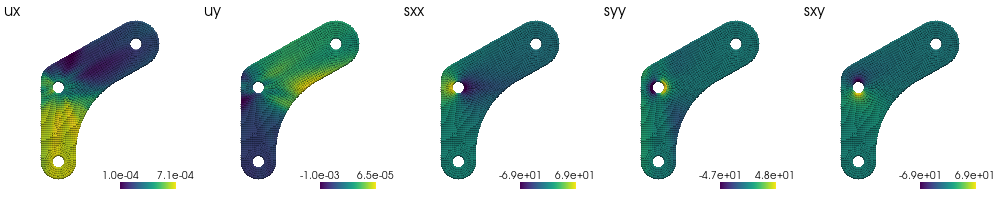

In [21]:
pred = model.predict(geom.mesh.points[:,:2])
predDf = pd.DataFrame(pred, columns=['ux', 'uy', 'sxx', 'syy', 'sxy'])
pc = pv.PolyData(geom.mesh.points)
plotScalarFields(pc, predDf)

In [22]:
lossPlot(losshistory, bcNames)

alt.Chart(...)

In [23]:
model.compile("adam", lr=0.001, loss_weights=lw)
losshistory, train_state = model.train(epochs=1000, display_every=100)

Compiling model...
'compile' took 0.937489 s

Training model...

Step      Train loss                                                                                                                            Test loss                                                                                                                             Test metric
2001      [4.18e+00, 2.30e+00, 4.36e-01, 2.12e-01, 8.53e-01, 8.32e-03, 8.27e-03, 1.26e+00, 1.36e+00, 9.57e-01, 3.00e-02, 2.81e+01, 1.34e+02]    [5.15e+00, 3.41e+00, 4.56e-01, 1.77e-01, 8.82e-01, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
2100      [4.46e+00, 2.30e+00, 3.64e-01, 1.88e-01, 6.93e-01, 5.12e-05, 3.25e-05, 1.23e+00, 1.34e+00, 9.58e-01, 2.32e-02, 2.80e+01, 1.34e+02]    [5.81e+00, 3.49e+00, 3.96e-01, 1.53e-01, 7.36e-01, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
2200      [3.94e+00, 2.14e+00, 3.28e-01, 1.61e-01, 6.07e-01, 3.68e-05, 2.73e-05

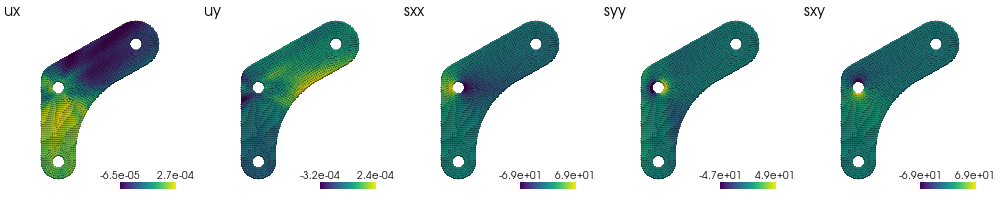

In [24]:
pred = model.predict(geom.mesh.points[:,:2])
predDf = pd.DataFrame(pred, columns=['ux', 'uy', 'sxx', 'syy', 'sxy'])
pc = pv.PolyData(geom.mesh.points)
plotScalarFields(pc, predDf)

In [25]:
lossPlot(losshistory, bcNames)

alt.Chart(...)

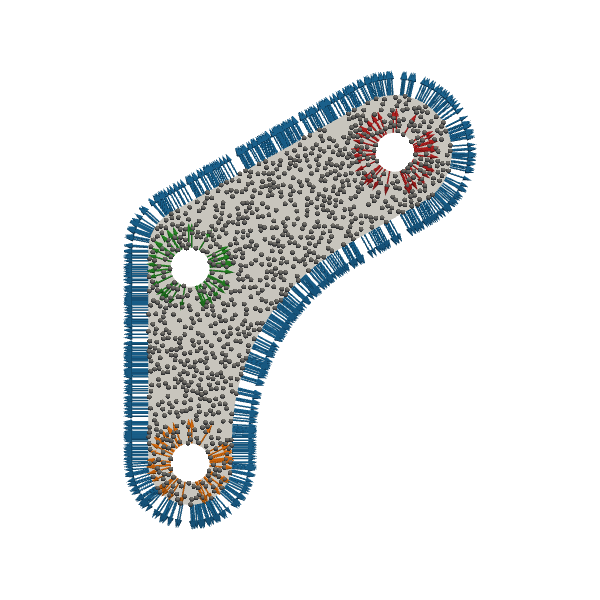

In [9]:
plotter = pv.Plotter(border=False)
plotter.set_background('white')
plotter.add_mesh(geom.mesh, show_edges=False)

# domain samples
pc = pv.PolyData(addZ(data.domainSamples))
plotter.add_mesh(pc, render_points_as_spheres=True, color='gray')

# boundary samples
colors = ['red', 'green', 'blue', 'yellow', 'purple', 'pink']
for bndId, color in zip(geom.bndDict.keys(), CATEGORY10):
    samples = addZ(data.bndSampleDict[bndId])
    normals = addZ(data.bndNormalsDict[bndId])
    plotter.add_arrows(samples, normals, 0.1, color=color)
plotter.show(window_size=(600,600), cpos='xy');